# image-level analysis

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns
from tqdm import tqdm

## constants

In [2]:
SOURCE_DATA_ROOT = pyprojroot.here('results/VSD/source_data/8-bins-uniform-strategy')

FIGURES_ROOT = pyprojroot.here('docs/paper/figures/experiment-2')

#### load dataframes

In [3]:
acc_df = pd.read_csv(SOURCE_DATA_ROOT.joinpath('acc.csv'))
rm_corr_df = pd.read_csv(SOURCE_DATA_ROOT.joinpath('rm_corr.csv'))

#### print number of trials per bin for one replicate
to show how binning strategy effects number of trials / samples per bin

In [19]:
for vsd_score_bin in acc_df.vsd_score_bin.unique():
    n_trials = acc_df[(acc_df['vsd_score_bin'] == vsd_score_bin) & (acc_df['replicate'] == 1)].n_trials.sum()
    print(f'number of trials in bin {vsd_score_bin}: {n_trials}')

number of trials in bin 0.0: 33468
number of trials in bin 1.0: 9184
number of trials in bin 2.0: 876
number of trials in bin 3.0: 296
number of trials in bin 4.0: 152
number of trials in bin 5.0: 8
number of trials in bin 6.0: 8
number of trials in bin 7.0: 8


## plot figure

In [11]:
def cm_to_inches(cm):
    return cm / 2.54

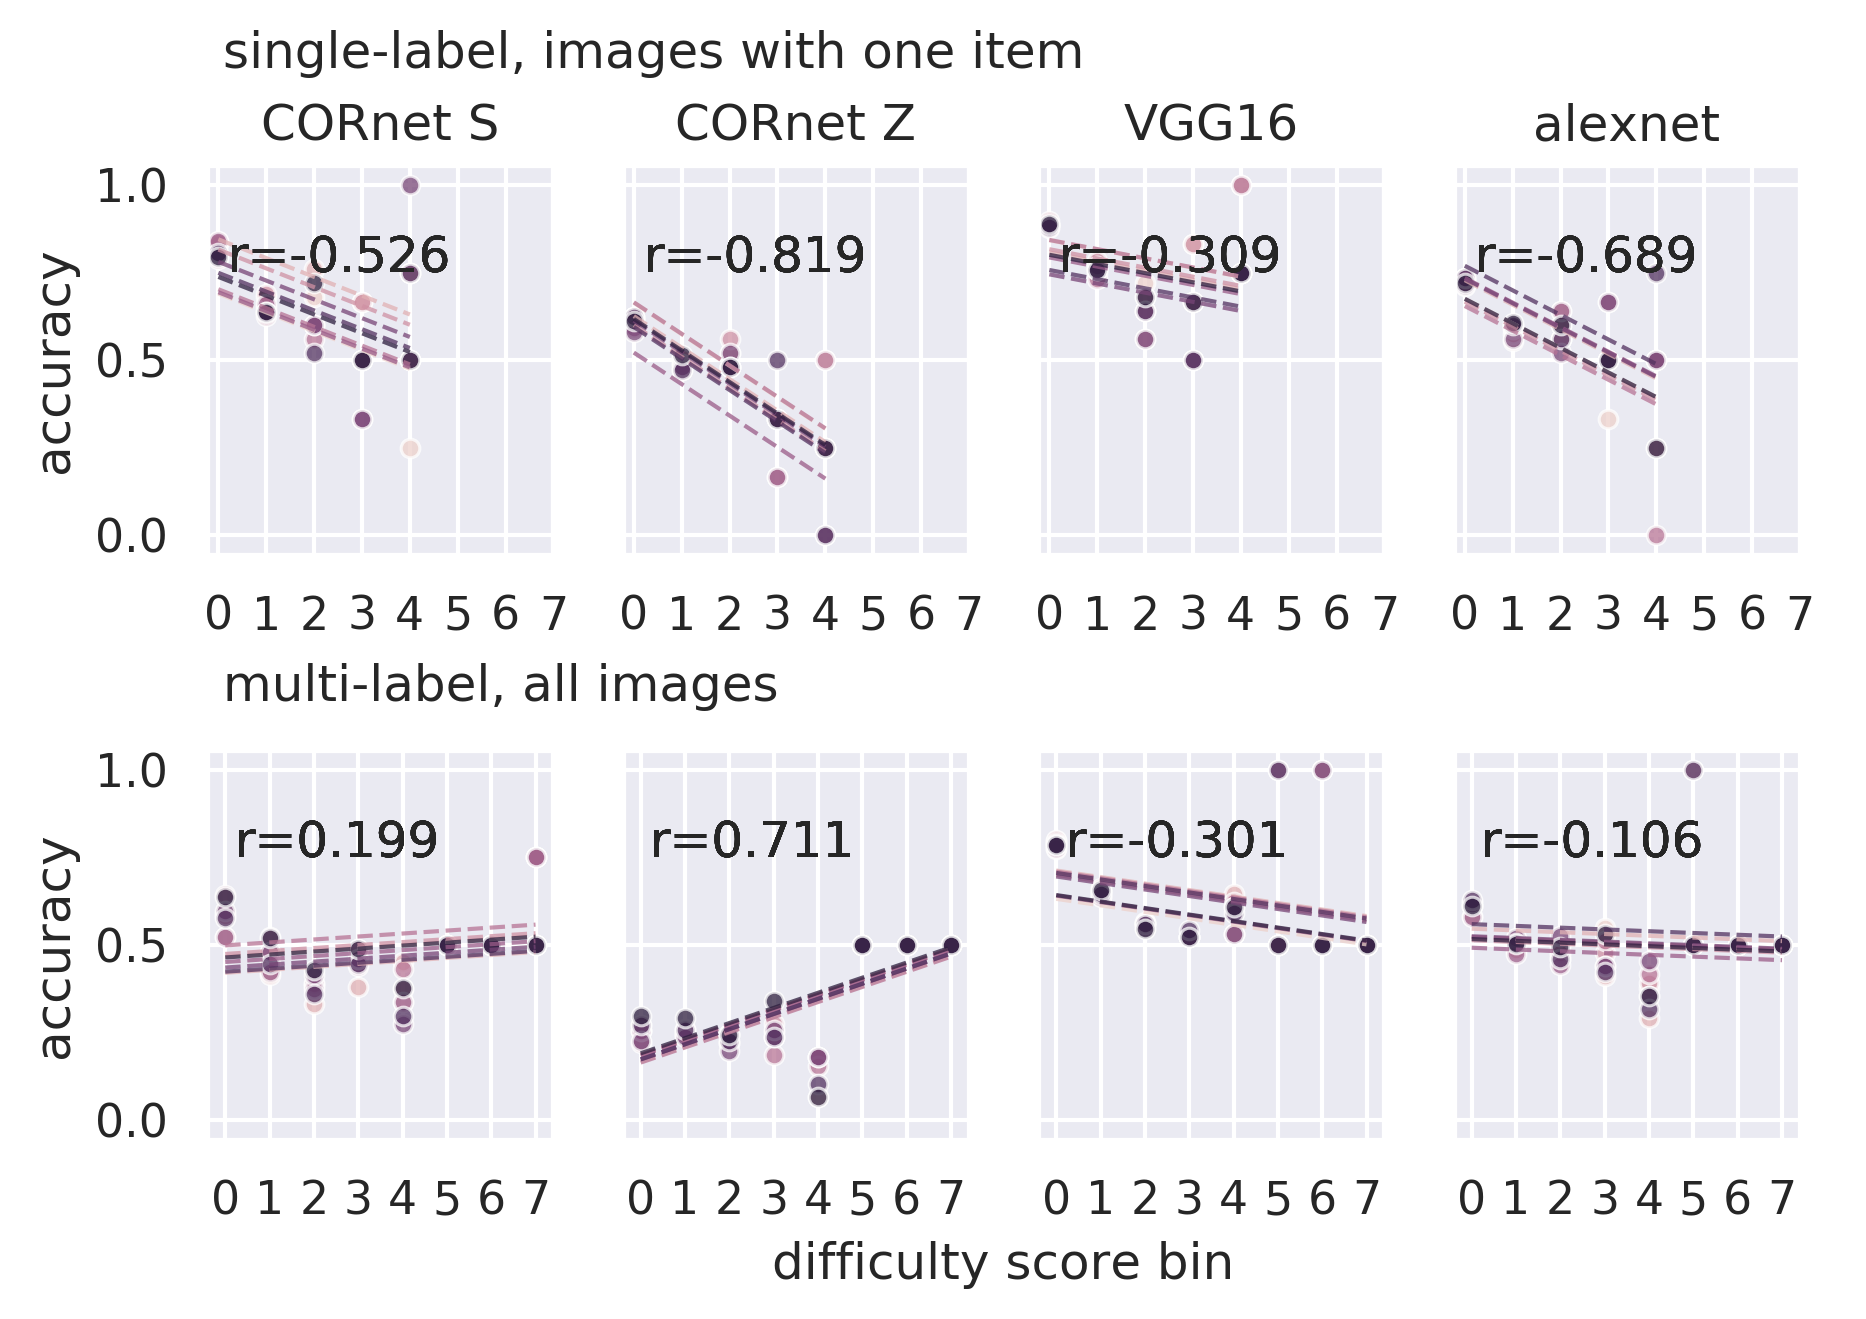

In [12]:
sns.set()
sns.set_palette(sns.cubehelix_palette(8))

nrow = 2  # single-label, multi-label
ncol = 4  # number of neural network architectures

FIGSIZE = tuple(cm_to_inches(size) for size in (17.4, 10))
DPI = 300
fig, ax = plt.subplots(nrow, ncol, figsize=FIGSIZE, dpi=DPI, sharey=True)
for mode in ['classify']:
    for method in ['transfer']:
        for row, loss_func in enumerate(['CE-random', 'BCE']):
            for col, net_name in enumerate(acc_df['net_name'].unique()):
                sub_df = acc_df[
                    (acc_df['mode'] == mode) &
                    (acc_df['method'] == method) &
                    (acc_df['loss_func'] == loss_func) &
                    (acc_df['net_name'] == net_name)
                ]
                if len(sub_df) == 0:
                    continue

                # sns.stripplot(x="vsd_score_bin", y="acc", hue="replicate", data=sub_df, ax=ax[row, col], size=2)
                for replicate in acc_df.replicate.unique():
                    replicate_df = sub_df[sub_df['replicate'] == replicate]                    
                    sns.regplot(x="vsd_score_bin", y="pred", scatter=False, ci=None, truncate=True, ax=ax[row, col], data=replicate_df,
                                line_kws={'linestyle': '--', 'linewidth': 1, 'alpha': 0.75})
                    sns.scatterplot(x="vsd_score_bin", y="acc", data=replicate_df, ax=ax[row, col],
                                    s=20, alpha=0.75)
                    r = rm_corr_df.loc[
                        ((rm_corr_df['mode'] == mode) & (rm_corr_df['method'] == method) & (rm_corr_df['loss_func'] == loss_func) & (rm_corr_df['net_name'] == net_name)),
                        'r'
                    ].values.item()
                    if r < -0.9:
                        ax[row, col].text(0.2, 0.2, f'r={r:.3f}')
                    else:
                        ax[row, col].text(0.2, 0.75, f'r={r:.3f}')

                ax[row, col].set_xlabel('')
                ax[row, col].set_xticks(acc_df['vsd_score_bin'].unique())
                # ax[row, col].set_xticklabels(xticklabels)
                if row == 0:
                    ax[row, col].set_title(net_name.replace('_', ' '))
                if col == 0:
                    ax[row, col].set_ylabel('accuracy')
                else:
                    ax[row, col].set_ylabel('')
            # g.fig.suptitle(f'accuracy as a function of visual search difficulty score,\nimages with only one item', y=1.05)

big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)
big_ax.set_xlabel("difficulty score bin")
big_ax.text(0.01, 1.1, "single-label, images with one item")
big_ax.text(0.01, 0.45, "multi-label, all images")


# fig.tight_layout(h_pad=2)
fig.subplots_adjust(top = 0.95, hspace=0.5)

for ext in ('svg', 'png'):
    fig_path = pyprojroot.here().joinpath(
        f'docs/paper/figures/experiment-2/acc-VSD-corr/acc-VSD-corr-{SOURCE_DATA_ROOT.name}.{ext}'
    )
    plt.savefig(fig_path, bbox_inches='tight')